# Emotion Classification with CNN using Keras

## Project Overview

The aim of this project is to develop a **Real Time Emotion Detection Model** using the **FER-2013 Dataset** (Face Expression Recognition). The model will be able to classify facial expressions in real-time via webcam. The original code, provided by Akshit Madan, can be found in this [Github repository](https://github.com/akmadan/Emotion_Detection_CNN). Several modifications have been made from the original code to try and improve the model's performance, such as searching for the optimized hyperparameters, and applying transfer learning. Additionally, an eye-color detection function has been integrated into the main script. Ultimately, the final model will not only be able to predict a person's mood but also detect their eye color. Let's get started!

### The Dataset
The dataset consists of 48x48 pixel grayscale images of faces expressing 7 different emotions:

* happy
* sad
* angry
* disgust
* surprise
* neutral
* fear

The dataset is pre-partioned into two subdirectories; training and validation data, and can be downloaded from [Kaggle](https://https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset).

In [2]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
#from google.colab import files     # used with Google Colab

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras_tuner import RandomSearch    # pip install keras-tuner when using Colab
from sklearn.utils import class_weight

# 1. Loading data from Kaggle
The first step in the project is to load the dataset, which is available for download on Kaggle. To save time and computational resources, we load the dataset directly using the Kaggle API and CLI. The following code is intended for use with Google Colab and can be ignored if the dataset has been downloaded manually and the notebook is run locally.

In [3]:
# ----- Ignore this step if dataset manually downloaded------ #

# Uploading my Kaggle API token
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
# Move the uploaded kaggle.json file to ~/.kaggle/
import os
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")

# Change permissions of kaggle.json file
import os
os.chmod("/root/.kaggle/kaggle.json", 0o600)

# Downloading the dataset via API
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

# Extracting the dataset
import zipfile
with zipfile.ZipFile('face-expression-recognition-dataset.zip', 'r') as zip_ref:
  zip_ref.extractall('dataset')

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
 87% 105M/121M [00:00<00:00, 142MB/s] 
100% 121M/121M [00:00<00:00, 152MB/s]


# 2. Data Exploration
With the dataset being uploaded to our current directory, it is time to do some exploration of the data. We do the following:

*   Displaying images by looping through the emotion directories in the training set, showing one image from each folder.
*   Investigating the class distribution by looping through the emotion directories for every emotion/class and count the images.

As shown below we can see that the categorization of the expressions are not perfectly clear all the time. We also find that the class distributions are heavily imbalanced. Let's review that again after splitting data into training and validation sets.

In [ ]:
# Setting the image size and pointing to the training data
img_size = (48, 48)
data_dir = 'dataset/images/train/'

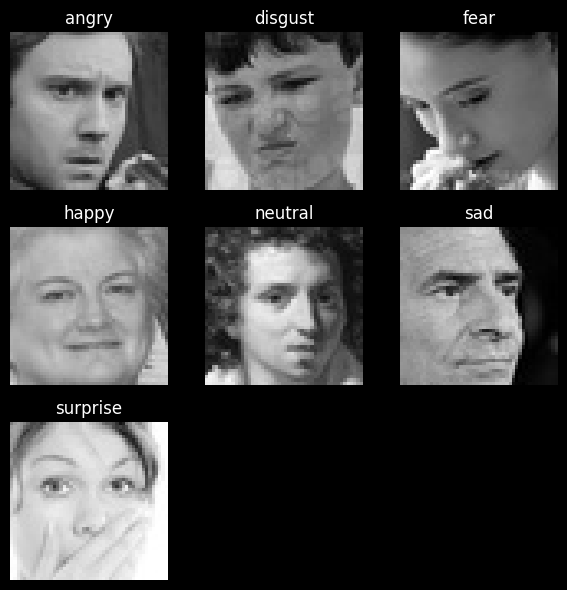

In [ ]:
# Create a figure for the subplots with a black bakground
plt.figure(0, figsize=(6, 6))
plt.style.use('dark_background')

# Initialize the counter
count = 0

# Loop through each expression directory
for expression in os.listdir(data_dir):
    expression_path = os.path.join(data_dir, expression)
    if os.path.isdir(expression_path):
        # Get the list of image files in the current expression directory
        image_files = os.listdir(expression_path)

        if image_files: 
            count += 1
            plt.subplot(3, 3, count)
            img_path = os.path.join(expression_path, image_files[0])
            img = load_img(img_path, target_size=img_size, interpolation='bicubic')  # Using bicubic interpolation to sharpen the image resolution
            plt.imshow(img, cmap="gray")
            plt.title(expression)
            plt.axis('off')

    if count >= 9:
        break  # This is used to exit the loop after 9 images being displayed!

# Display plot
plt.tight_layout()
plt.show()


angry: 3993 images
disgust: 436 images
fear: 4103 images
happy: 7164 images
neutral: 4982 images
sad: 4938 images
surprise: 3205 images


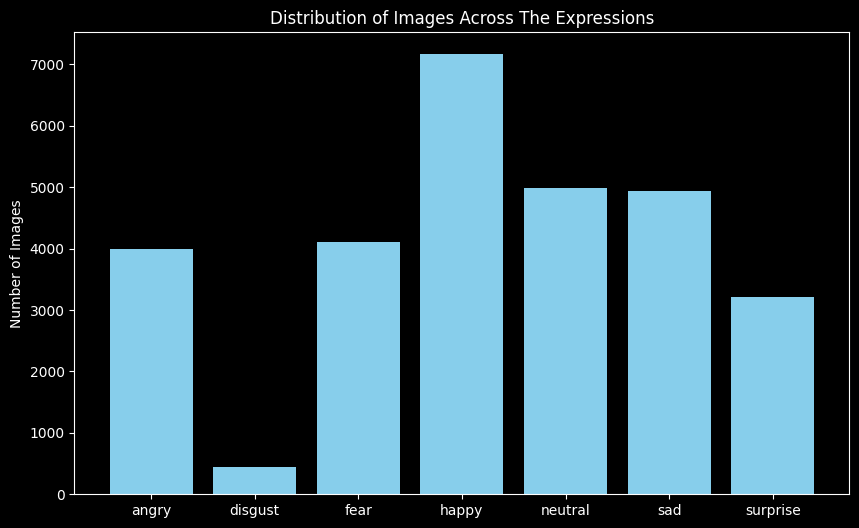

In [ ]:
# Initialize a dictionary to hold the counts
expression_counts = {}

# Loop through each expression directory and count the images
for expression in os.listdir(data_dir):
    expression_path = os.path.join(data_dir, expression)
    if os.path.isdir(expression_path):
        image_files = os.listdir(expression_path)
        expression_counts[expression] = len(image_files)

# Print the distribution
for expression, count in expression_counts.items():
    print(f"{expression}: {count} images")

# Plot the distribution as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(expression_counts.keys(), expression_counts.values(), color='skyblue')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across The Expressions')
plt.show()

# 3. Dividing dataset into training / validation sets and applying data augmentation

In the next step of the project, we use Keras ImageDataGenerator to perform several data augmentation techniques, such as rotation, shifting, shearing, zooming, and flipping. We also scale the images pixel values from the range of [0,255] to range [0,1]. Normalizing the input data makes it easier for the model to learn, thereby improving the training performance. Data augmentation also helps to avoid overfitting by presenting the model with different versions of the same image, which enhances the model's ability to generalize.

The method flow_from_directory is provided by the ImageDataGenerator class and is used to load the datasets into the generator.

The dataset is divided into training and validation sets based on the existing partitioning in the subdirectories. It is important to note that data augmentation is only applied to the training data, ensuring that the validation data remains a true representation of real-world scenarios. This project does not include a test set for the reason being that the model's performance on live webcam data will work as the final evaluation!

In [9]:
batch_size = 128
data_dir = 'dataset/images/'

# Define ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only preprocessing done to validation data is scaling
val_datagen = ImageDataGenerator(rescale=1./255)

# Load training data into train set
train_set = train_datagen.flow_from_directory(
    data_dir + 'train',
    target_size=(48, 48),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

# Load validation data into validation set
val_set = val_datagen.flow_from_directory(
    data_dir + 'validation',
    target_size=(48, 48),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

# Verify that we managed to extract the correct classes
class_names = train_set.class_indices
print('Class names: ', class_names)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Class names:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


After defining the data partitioning, we will check the distribution of classes in each set to follow up on the imbalance shown earlier. As shown below, and as concluded earlier, we find that the class distribution is imbalanced. Specifically, the "happy" class is greatly overrepresented, while the "disgust" class is notably underrepresented. This could become a problem when training the model, as the model may disproportionately adjust to the "happy" class.

In [ ]:
# Get the class indices from the generators
train_class_indices = train_set.class_indices
test_class_indices = val_set.class_indices

# Invert the dictionary to map indices to class names
train_class_names = {v: k for k, v in train_class_indices.items()}
test_class_names = {v: k for k, v in test_class_indices.items()}

# Convert class indices to class names for each dataset
train_class_labels = [train_class_names[i] for i in train_set.classes]
test_class_labels = [test_class_names[i] for i in val_set.classes]

# Create pandas Series from the class labels
train_class_distribution = pd.Series(train_class_labels).value_counts()
test_class_distribution = pd.Series(test_class_labels).value_counts()

print("Training Set Class Distribution:")
print(train_class_distribution)
print()
print("Validation Set Class Distribution:")
print(test_class_distribution)

Training Set Class Distribution:
happy       5732
neutral     3986
sad         3951
fear        3283
angry       3195
surprise    2564
disgust      349
Name: count, dtype: int64

Validation Set Class Distribution:
happy       1432
neutral      996
sad          987
fear         820
angry        798
surprise     641
disgust       87
Name: count, dtype: int64


## 3.1 Handling class imbalances in the data

To handle the potential problem with class imbalances in the training data, the class_weight function from scikit-learn's library is introduced. This function enables us to adjust the weights of different classes in the training data, thereby addressing imbalanced class distributions. In this step, we initialize and calculate the class weights, for it to later be used as a parameter during training. By assigning appropriate weights to each class, the aim is to reduce the impact of imbalances.

Visualizing the new class distribution shows us how the weight assigned to the "disgusted" class is set substantially higher, making up for its underrepresentation in the dataset. The same goes for the "happy" class which weights are now lowered compared to the rest of the classes.

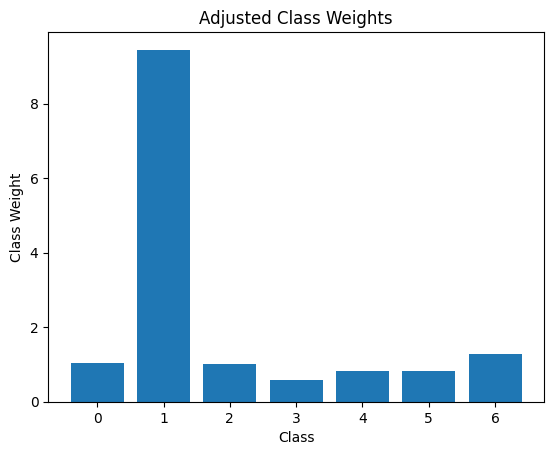

In [10]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_set.classes),
    y=train_set.classes
)

class_weights_dict = dict(enumerate(class_weights))

# Plot new weights
plt.bar(class_weights_dict.keys(), class_weights_dict.values())
plt.xlabel('Class')
plt.ylabel('Class Weight')
plt.title('Adjusted Class Weights')
plt.xticks(list(class_weights_dict.keys()))
plt.show()

# 4. Modelling
## 4.1 Building the model
To create the model we will use the architecture provided by Akshit Madan.
The following code is building a Sequential model with four Convolutional Neural Network (CNN) layers and two Dense layers. ReLu is used as activation function, and each convolutional layer is followed by a max-pooling layer. Both the CNN layers and the Dense layers are followed by batch normalization to normalize the activations of the previous layer, and dropout layers for regularization.

The model is compiled using the Adam optimizer, and categorical cross-entropy is used as the loss function since it's a multiclass classification problem. Some minor modifications have been done to the model compilation from the original code.


In [11]:
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))

opt = Adam()   # Setting lr to default of Adam opt (0.001), since we will be using RLR as callback later
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_6 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)      

## 4.2 Training the model

Callbacks such as ModelCheckpoint, Early Stopping and Reduce Learning Rate are included during training to fine-tune the training process, save the best model and stop when the model is no longer improving. Changes that have been made from the original code is setting patience to 5 for Early Stopping instead of 3, as this would intervene with the function of Reduce Learning Rate which has the same number of patience.

Additionally, the class_weight parameter is used during training to rectify class imbalances.

In [14]:
# Set the number of epochs for training
epochs = 48

# Checkpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('model_1.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Early stopping to prevent overfitting by monitoring validation loss
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

# Reduce learning rate when validation loss has stopped improving
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)

# List of callbacks to be applied during training
callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

# Train the model
history = model.fit(
    train_set,
    epochs=epochs,
    validation_data=val_set,
    class_weight=class_weights_dict,
    callbacks=callbacks_list
)

Epoch 1/48
226/226 [==============================] - ETA: 0s - loss: 1.8404 - accuracy: 0.2507
Epoch 1: val_accuracy improved from -inf to 0.27455, saving model to model_1.h5
226/226 [==============================] - 29s 127ms/step - loss: 1.8404 - accuracy: 0.2507 - val_loss: 1.7980 - val_accuracy: 0.2746 - lr: 0.0010
Epoch 2/48


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


226/226 [==============================] - ETA: 0s - loss: 1.7757 - accuracy: 0.2932
Epoch 2: val_accuracy did not improve from 0.27455
226/226 [==============================] - 28s 124ms/step - loss: 1.7757 - accuracy: 0.2932 - val_loss: 1.8990 - val_accuracy: 0.2446 - lr: 0.0010
Epoch 3/48
226/226 [==============================] - ETA: 0s - loss: 1.7078 - accuracy: 0.3243
Epoch 3: val_accuracy improved from 0.27455 to 0.38225, saving model to model_1.h5
226/226 [==============================] - 31s 138ms/step - loss: 1.7078 - accuracy: 0.3243 - val_loss: 1.6090 - val_accuracy: 0.3823 - lr: 0.0010
Epoch 4/48
226/226 [==============================] - ETA: 0s - loss: 1.6385 - accuracy: 0.3568
Epoch 4: val_accuracy improved from 0.38225 to 0.40631, saving model to model_1.h5
226/226 [==============================] - 28s 124ms/step - loss: 1.6385 - accuracy: 0.3568 - val_loss: 1.5706 - val_accuracy: 0.4063 - lr: 0.0010
Epoch 5/48
226/226 [==============================] - ETA: 0s - l

In [16]:
model.save('model_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 4.3 Plotting Accuracy & Loss
Plotting the training and validation loss curves together with the training and validation accuracy curves. Using this plot we can see how well the model is learning and how well it is generalizing to unseen data. As shown by the plot the model does not seem to be overfitting.

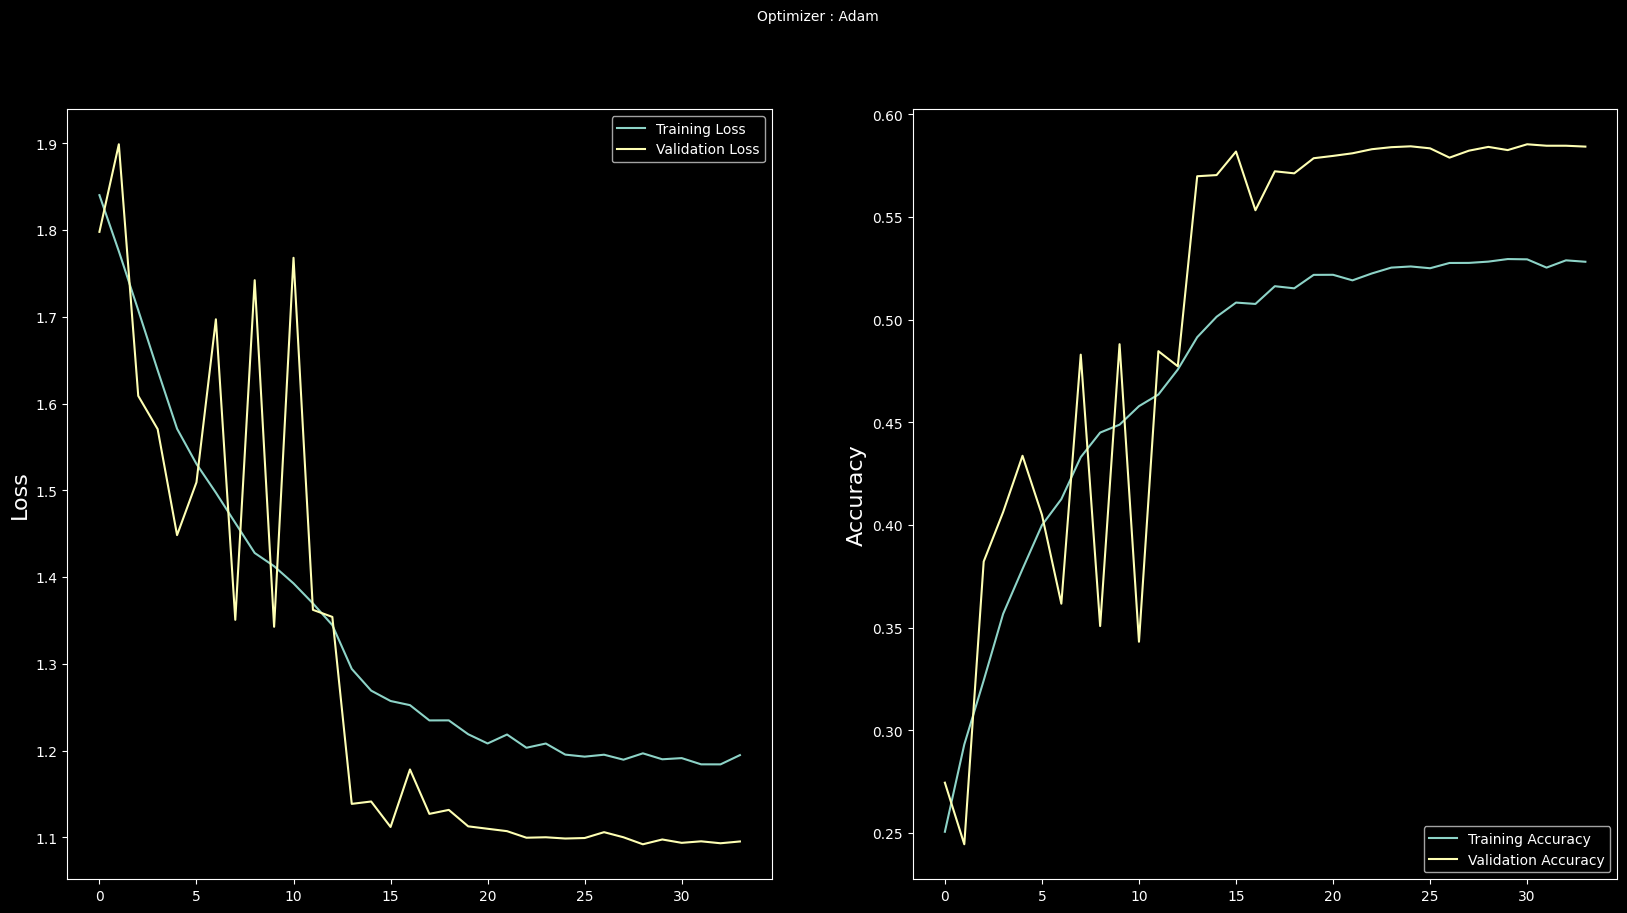

In [15]:
plt.style.use('dark_background')

# Plotting loss curves
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

## 4.4 Evaluating model on validation set
The following code is used to evaluate the model's performance on the validation set. Usually, one would use a separate test set containing data that the model has not been exposed to. Since the validation data was used during training the following metrics should be intepreted with caution. However, for this project we do not use a test set as the final evaluation will be conducted when trying out the model via webcam.

In [17]:
from tensorflow.keras.models import load_model

model = load_model('model_1.h5')

# Recompile the model with the same optimizer and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(val_set)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

56/56 [==============================] - 3s 50ms/step - loss: 1.0921 - accuracy: 0.5842
Test Loss: 1.0921012163162231
Test Accuracy: 0.5842060446739197


# 4.5 Hyperparameter tuning
Next we will conduct hyperparameter tuning using KerasTuner and RandomSearch. This is done to investigate whether we can reach better performance using different settings for the trainable parameters, such as varying the number of layers and kernel sizes.

In [ ]:
# Building the model with adjustable hyperparams to be able to tune with KerasTuner

def build_model(hp):
    model = Sequential()

    # First CNN layer
    model.add(Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('kernel_1', values=[3,5]),
        padding='same',
        activation='relu',
        input_shape=(48,48,1)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # Second CNN layer
    model.add(Conv2D(
        filters=hp.Int('filters_2', min_value=64, max_value=512, step=64),
        kernel_size=hp.Choice('kernel_2', values=[3,5]),
        padding='same',
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # Third CNN layer
    model.add(Conv2D(
        filters=hp.Int('filters_3', min_value=128, max_value=1024, step=128),
        kernel_size=hp.Choice('kernel_3', values=[3,5]),
        padding='same',
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # Flatten layer
    model.add(Flatten())

    # Dense layers
    model.add(Dense(
        units=hp.Int('dense_units_1', min_value=256, max_value=1024, step=128),
        activation='relu'
    ))
    model.add(Dropout(0.25))

    model.add(Dense(
        units=hp.Int('dense_units_2', min_value=256, max_value=1024, step=128),
        activation='relu'
    ))
    model.add(Dropout(0.25))

    # Output layer
    model.add(Dense(7, activation='softmax'))

    ### Compile model
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
epochs = 48

checkpoint = ModelCheckpoint('model_1.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=5,
                               verbose=1,
                               restore_best_weights=True
                              )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=3,
                                        verbose=1,
                                        min_delta=0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

In [ ]:
from kerastuner.tuners import RandomSearch

# Defining the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials= 5,
    executions_per_trial= 3,
    overwrite=True
)

C:\Users\Ibseey\AppData\Local\Temp\ipykernel_9032\2690224842.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch
C:\Users\Ibseey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Perform the hyperparameter search
tuner.search(train_set,
             epochs=48,
             validation_data=validation_set,
             class_weight=class_weights_dict,
             callbacks=callbacks_list)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
256               |256               |filters_1
5                 |5                 |kernel_1
512               |512               |filters_2
3                 |3                 |kernel_2
256               |256               |filters_3
3                 |3                 |kernel_3
512               |512               |dense_units_1
384               |384               |dense_units_2
0.001             |0.001             |learning_rate


Epoch 1/48


C:\Users\Ibseey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1584 - loss: 2.9065
Epoch 1: val_accuracy improved from -inf to 0.01571, saving model to model_1.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 903s 4s/step - accuracy: 0.1584 - loss: 2.9039 - val_accuracy: 0.0157 - val_loss: 2.0765 - learning_rate: 0.0010
Epoch 2/48
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1665 - loss: 1.9575
Epoch 2: val_accuracy improved from 0.01571 to 0.18058, saving model to model_1.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 899s 4s/step - accuracy: 0.1665 - loss: 1.9575 - val_accuracy: 0.1806 - val_loss: 1.9219 - learning_rate: 0.0010
Epoch 3/48
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1946 - loss: 1.9119
Epoch 3: val_accuracy improved from 0.18058 to 0.18624, saving model to model_1.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 883s 4s/step - accuracy: 0.1946 - loss: 1.9119 - val_accuracy: 0.1862 - val_loss: 1.9083 - learning_rate: 0.0010
Epoch 4/48
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1896 - los

KeyboardInterrupt: 

### 4.5.1 Findings from hyperparameter tuning

!! The results shown above is from an interrupted search, but the findings below are from the original search that was unfortunately overwritten !! 

We found that the validation accuraccy remained largely unchanged compared to the accuraccy measured using the original model architecture. An explanation to this could be that the author designed the model architecture based on prior hyperparameter tuning searches, optimizing for the best performance.

# 5. Further steps for model improvements
Based on the findings from the hyperparameter tuning, it appears that the model architecture has already been fine-tuned by the author. Because of this, additional hyperparameter exploration may not be useful to significantly improve the model's performance. As shown during the EDA we also found that the dataset is not perfect. Optimizing the model architecture will make no difference if the data does not improve.

## 5.1 Transfer Learning
Another method that could be useful for potentially enhancing the model's performance is that of transfer learning. The model architecture used was the VGGNET-16 with weights pretrained on ImageNet. The VGG16 is considered to be one of the best computer vision models to date. To learn more about the VGG16 architecture, check out [VGGNet-16 Architecture: A Complete Guide](https://www.kaggle.com/code/blurredmachine/vggnet-16-architecture-a-complete-guide) on Kaggle.

However, looking at other people's results using pretrained VGG16 on FRE Dataset (to use as benchmark) it looks like it does not yield very good results. This could be due to the model being pretrained on ImageNet 224x224 pixel color images, while the FER dataset is 48x48 grayscale images.

In this project attempts were made to both use the original input shape of 48x48 but also to resize the FER dataset images to the input shape expected by the pretrained model. In the first attempt when resizing to 224x224 pixels a val_accuracy of 67% was reached. But when trying out the model, it did not perform very well with the webcam live data.

Further exploration is needed to use the full potential of transfer learning in enhancing model performance on the FER Dataset.


In [ ]:
# Define the paths for the dataset
train_dir = 'dataset/images/train'
validation_dir = 'dataset/images/validation'

# Define ImageDataGenerator for data augmentation and preprocessing
train_data_generator_vgg16 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_data_generator_vgg16 = ImageDataGenerator(
    rescale=1./255
)

# Load training data into train set for VGG16
train_set_vgg16 = train_data_generator_vgg16.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

# Load validation data into validation set for VGG16
validation_set_vgg16 = val_data_generator_vgg16.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

# Check the shape of the training set
batch_x, batch_y = next(train_set_vgg16)
print('Shape of image batch:', batch_x.shape)   # The images have been correctly reshaped to 224x224 pixels and 3 channels (RGB)
print('Shape of label batch:', batch_y.shape)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Shape of image batch: (64, 224, 224, 3)
Shape of label batch: (64, 7)


In [ ]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
model_vgg16 = Sequential([
    base_model,
    Flatten(),
    Dense(256),  # Tried with a bunch of different additional layers, in the last one I tried to keep it as simple as possible
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # Output layer with 7 units (assuming 7 classes)
])

# Compile the model
model_vgg16.compile(loss='categorical_crossentropy',
                     optimizer=Adam(),
                     metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('model_VGG16.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, restore_best_weights=True)
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_delta=0.0001)
callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

# Training and validating on a fraction of the dataset, to speed up training
train_fraction = 0.1
validation_fraction = 0.1

total_train_samples = train_set_vgg16.samples
total_validation_samples = validation_set_vgg16.samples

train_steps = int(total_train_samples * train_fraction / train_set_vgg16.batch_size)
validation_steps = int(total_validation_samples * validation_fraction / validation_set_vgg16.batch_size)

history_vgg16 = model_vgg16.fit(
    train_set_vgg16,
    steps_per_epoch=train_steps,
    epochs=48,
    validation_data=validation_set_vgg16,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/48
45/45 [==============================] - ETA: 0s - loss: 2.1208 - accuracy: 0.2993
Epoch 1: val_accuracy improved from -inf to 0.29403, saving model to model_VGG16.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 58s 959ms/step - loss: 2.1208 - accuracy: 0.2993 - val_loss: 4.3954 - val_accuracy: 0.2940 - lr: 0.0010
Epoch 2/48
45/45 [==============================] - ETA: 0s - loss: 1.8702 - accuracy: 0.3260
Epoch 2: val_accuracy improved from 0.29403 to 0.35653, saving model to model_VGG16.h5
45/45 [==============================] - 43s 948ms/step - loss: 1.8702 - accuracy: 0.3260 - val_loss: 2.3258 - val_accuracy: 0.3565 - lr: 0.0010
Epoch 3/48
45/45 [==============================] - ETA: 0s - loss: 1.7108 - accuracy: 0.3667
Epoch 3: val_accuracy did not improve from 0.35653
45/45 [==============================] - 43s 962ms/step - loss: 1.7108 - accuracy: 0.3667 - val_loss: 2.1471 - val_accuracy: 0.3381 - lr: 0.0010
Epoch 4/48
45/45 [==============================] - ETA: 0s - loss: 1.6589 - accuracy: 0.3795
Epoch 4: val_accuracy improved from 0.35653 to 0.41619, saving model to model_VGG16.h5
45/45 [==============================] - 42s 935ms/step - 

In [ ]:
# Unfreeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = True

# Compiling the model again
model_vgg16.compile(loss='categorical_crossentropy',
                     optimizer=Adam(learning_rate=0.0001),  # Using a smaller learning rate for fine-tuning
                     metrics=['accuracy'])

# Fine-tune the model on the entire training set
fine_tune_epochs = 10
history_fine_tune = model_vgg16.fit(
    train_set_vgg16,
    epochs=fine_tune_epochs,
    validation_data=validation_set_vgg16,
    callbacks=callbacks_list
)

Epoch 1/10
451/451 [==============================] - ETA: 0s - loss: 1.4786 - accuracy: 0.4329
Epoch 1: val_accuracy did not improve from 0.50000
451/451 [==============================] - 541s 1s/step - loss: 1.4786 - accuracy: 0.4329 - val_loss: 1.3271 - val_accuracy: 0.4976 - lr: 1.0000e-04
Epoch 2/10
451/451 [==============================] - ETA: 0s - loss: 1.2328 - accuracy: 0.5312
Epoch 2: val_accuracy improved from 0.50000 to 0.57048, saving model to model_VGG16.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


451/451 [==============================] - 532s 1s/step - loss: 1.2328 - accuracy: 0.5312 - val_loss: 1.1446 - val_accuracy: 0.5705 - lr: 1.0000e-04
Epoch 3/10
451/451 [==============================] - ETA: 0s - loss: 1.1390 - accuracy: 0.5688
Epoch 3: val_accuracy improved from 0.57048 to 0.60105, saving model to model_VGG16.h5
451/451 [==============================] - 538s 1s/step - loss: 1.1390 - accuracy: 0.5688 - val_loss: 1.0728 - val_accuracy: 0.6010 - lr: 1.0000e-04
Epoch 4/10
451/451 [==============================] - ETA: 0s - loss: 1.0850 - accuracy: 0.5937
Epoch 4: val_accuracy improved from 0.60105 to 0.62765, saving model to model_VGG16.h5
451/451 [==============================] - 536s 1s/step - loss: 1.0850 - accuracy: 0.5937 - val_loss: 0.9988 - val_accuracy: 0.6277 - lr: 1.0000e-04
Epoch 5/10
451/451 [==============================] - ETA: 0s - loss: 1.0433 - accuracy: 0.6064
Epoch 5: val_accuracy did not improve from 0.62765
451/451 [==============================]

# 6. Conclusions

By experimenting with this dataset and trying out different techniques to build and train a model to do the task right, the main conclusion is that the dataset should probably have been reviewed and cleaned before trying to improve the model's performance. 

The eye color detector is working - sometimes predicting blue and sometimes green - which is fair enough because I have a mix between blue and green eyes. However, this one could definitely be improved in terms of specifying more detailed color ranges and applying more image preprocessing, since it is currently performing best with proper lightning. These improvements could possibly be a focus for my next computer vision project!


### 1. Utmaningar du haft under arbetet samt hur du hanterat dem.

Frustration över att inte ha tillräckligt kraftfull GPU för att kunna träna modellen lokalt (för oj vad mycket träning det har blivit). Istället har jag skapat några extra mejladresser för att få större tillgång till Google Colabs gratis GPU-användning. Andra utmaningar har varit att försöka komma på en funktionalitet som faktiskt är användbar, vilket kändes svårt under förutsättningen att 'emotion-detection' skulle vara the main character. Hanterade det genom att göra något annat än 'gender' eller 'age detection' - vilket nu i efterhand kanske ändå hade varit mer rimligt - och istället implementera en ögonfärgspredikterare. Den funkar, men vad jag ska ha den till vet jag inte riktigt.

### 2. Vilket betyg du anser att du skall ha och varför.

Jag anser att jag har uppfyllt kriterierna för VG - även om jag inte är helt nöjd med min modells "funktionella betydelse".

### 3. Tips du hade "gett dig själv" i början av kursen nu när du slutfört den. 

Troligtvis att försöka gå vidare och inte spendera alldeles för många timmar på att försöka få en bättre grundmodell. Det är högst sannolikt kvaliteten på datasetet som gör att modellen inte blir mycket bättre - vilka tekniker man än provar. 